In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
from concurrent.futures import ThreadPoolExecutor
import os
from tqdm import tqdm
from rich import print

In [2]:
size = (224, 224)
classes = ['Autistic', 'Non_Autistic']

In [3]:
def ld_img(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Failed to load image: {path}")
    img = cv2.cvtColor(cv2.resize(img, size), cv2.COLOR_BGR2RGB)
    
    folder_name = os.path.basename(os.path.dirname(path))
    label = classes.index(folder_name) if folder_name in classes else -1
    
    return img / 255.0, label

def ld(folder_path, max_workers=8):
    paths = glob.glob(os.path.join(folder_path, '**', '*.[jp][pn][g]'), recursive=True)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(ld_img, paths), total=len(paths), desc="Read"))
    
    images, labels = zip(*results) if results else ([], [])
    print(f'Loaded {len(images)} images from {folder_path}')
    return np.array(images), np.array(labels)

In [4]:
X_train, y_train = ld('../datasets/train')
X_val, y_val = ld('../datasets/valid')
X_test, y_test = ld('../datasets/test')

Read: 100%|██████████| 2540/2540 [00:01<00:00, 1347.51it/s]


Loaded 2540 images from ../datasets/train

Read: 100%|██████████| 100/100 [00:00<00:00, 1363.52it/s]


Loaded 100 images from ../datasets/valid

Read: 100%|██████████| 300/300 [00:00<00:00, 1288.87it/s]


Loaded 300 images from ../datasets/test

In [5]:
print(f'Latih: {X_train.shape}, Validasi: {X_val.shape}, Test: {X_test.shape}')

Latih: (2540, 224, 224, 3), Validasi: (100, 224, 224, 3), Test: (300, 224, 224, 3)

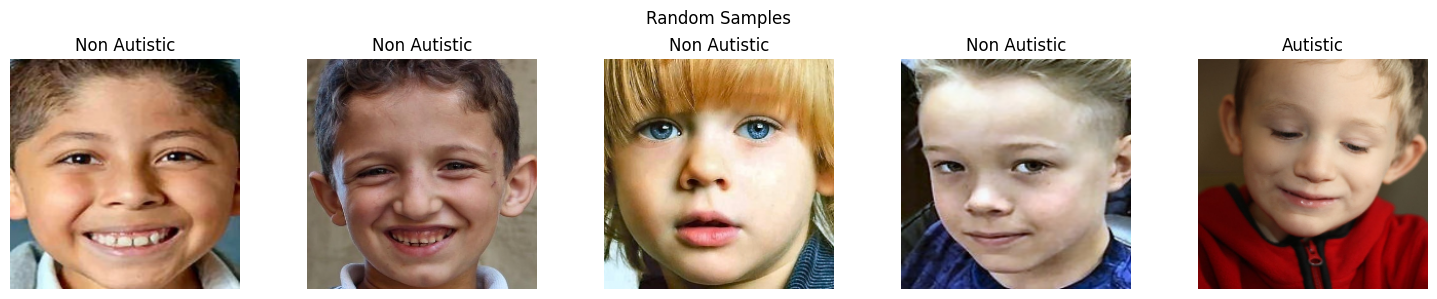

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X_train))
    ax.imshow(X_train[idx])
    ax.set_title(f"{'Autistic' if y_train[idx] == 0 else 'Non Autistic'}")
    ax.axis('off')
plt.suptitle('Random Samples')
plt.tight_layout()
plt.show()

In [7]:
print(X_train.shape)

(2540, 224, 224, 3)

In [8]:
# Data Augmentation Layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [9]:
# Model dengan arsitektur lebih dalam + Batch Normalization + Dropout
model = keras.Sequential([
    layers.Input(shape=(size[0], size[1], 3)),
    
    # Data Augmentation
    data_augmentation,
    
    # Block 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),
    
    # Block 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),
    
    # Block 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),
    
    # Block 4
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.4),
    
    # Dense Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [10]:
# Compile dengan optimizer lebih baik
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)     

In [11]:
# Callbacks untuk meningkatkan training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        '../model/best_autism_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20


159/159 [==============================] - ETA: 0s - loss: 0.7752 - accuracy: 0.6114
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ../model\best_autism_model.h5


d:\Development\Python\Autism_classifier\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


159/159 [==============================] - 224s 1s/step - loss: 0.7752 - accuracy: 0.6114 - val_loss: 1.1115 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
159/159 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.6287
Epoch 2: val_accuracy did not improve from 0.50000
159/159 [==============================] - 222s 1s/step - loss: 0.6961 - accuracy: 0.6287 - val_loss: 1.6212 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
159/159 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.6516
Epoch 3: val_accuracy improved from 0.50000 to 0.59000, saving model to ../model\best_autism_model.h5
159/159 [==============================] - 220s 1s/step - loss: 0.6546 - accuracy: 0.6516 - val_loss: 0.7464 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 4/20
159/159 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.6819
Epoch 4: val_accuracy improved from 0.59000 to 0.62000, saving model to ../model\best_autism_model.h5
159/159 [=============

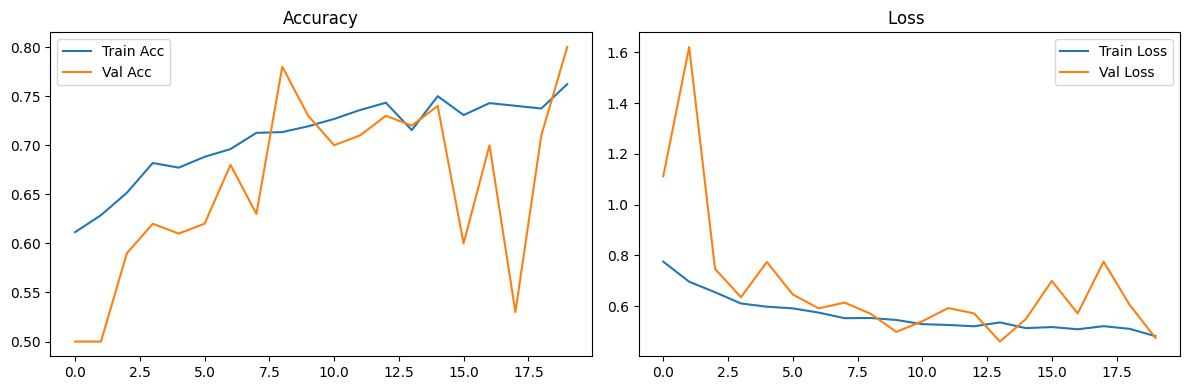

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['accuracy'], label='Train Acc')
ax1.plot(history.history['val_accuracy'], label='Val Acc')
ax1.set_title('Accuracy')
ax1.legend()
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Loss ')
ax2.legend()
plt.tight_layout()
plt.show()

10/10 [==============================] - 7s 667ms/step


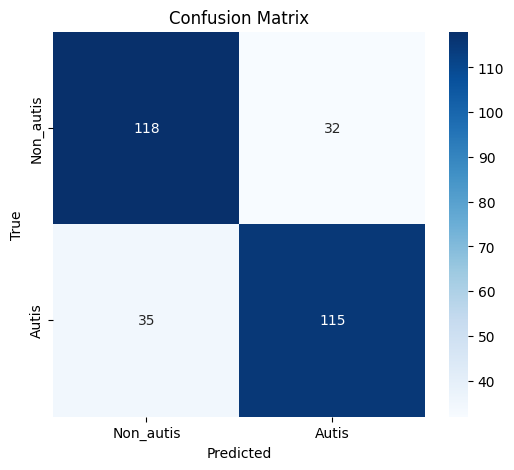

In [13]:
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non_autis', 'Autis'], yticklabels=['Non_autis', 'Autis'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [14]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Non_autis', 'Autis']))

Classification Report:

precision    recall  f1-score   support

   Non_autis       0.77      0.79      0.78       150
       Autis       0.78      0.77      0.77       150

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300

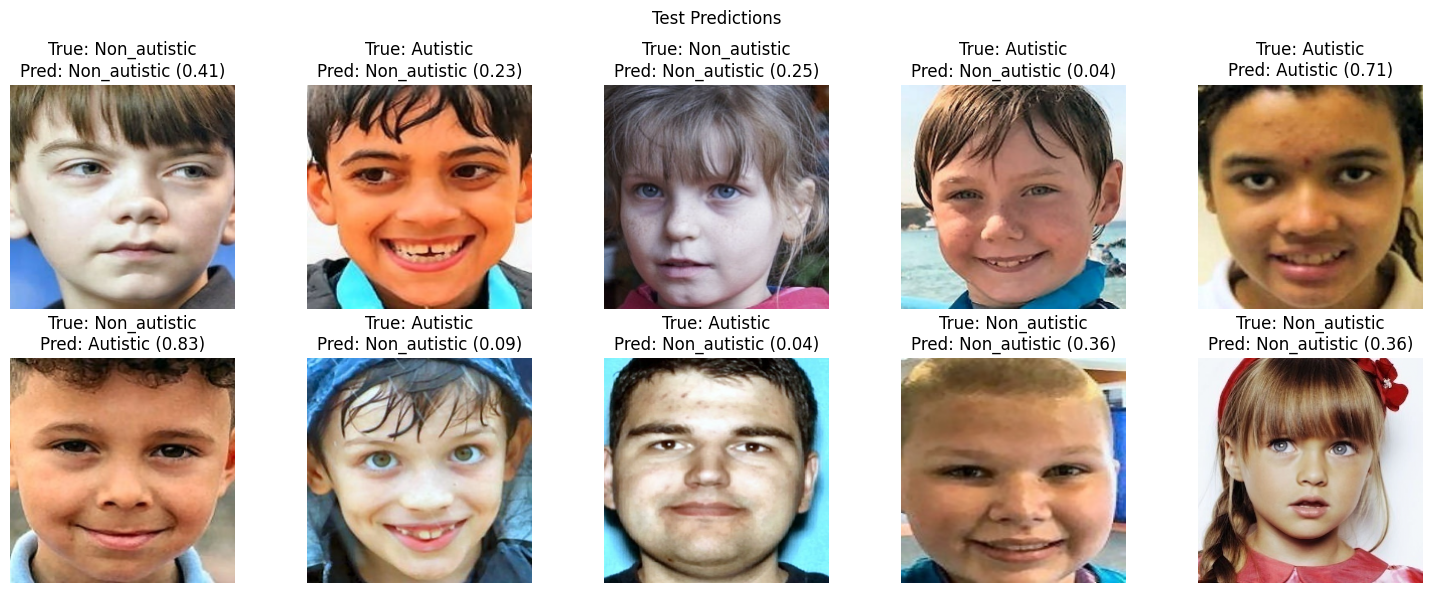

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax in axes.flat:
    idx = np.random.randint(0, len(X_test))
    pred = model.predict(X_test[idx:idx+1], verbose=0)[0][0]
    ax.imshow(X_test[idx])
    ax.set_title(f"True: {'Autistic' if y_test[idx] == 0 else 'Non_autistic'}\nPred: {'Autistic' if pred > 0.5 else 'Non_autistic'} ({pred:.2f})")
    ax.axis('off')
plt.suptitle('Test Predictions')
plt.tight_layout()
plt.show()

In [16]:
model.save('../model/autism_cnn_model.h5')

d:\Development\Python\Autism_classifier\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
